In [1]:
import h2o
import matplotlib as plt
%matplotlib inline

from h2o.automl import H2OAutoML

import shap


In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...


In [3]:
insurance = h2o.import_file('./data/motor_veh_ins_data_cleaned.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


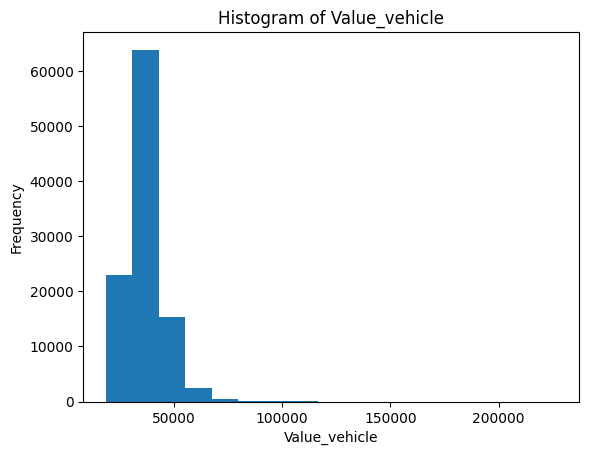

breaks,counts,mids_true,mids,widths
12515.2,nan,nan,nan,nan
24759.9,23017,135.23,18637.6,12244.7
37004.7,63905,6258.5,30882.3,12244.7
49249.4,15364,12380,43127.1,12244.7
61494.2,2445,18502.4,55371.8,12244.7
73738.9,498,24650,67616.5,12244.7
85983.6,194,30778.5,79861.3,12244.7
98228.4,60,38400,92106,12244.7
110473,31,43765.7,104351,12244.7
122718,12,49865,116596,12244.7


In [4]:
insurance["Value_vehicle"].hist()

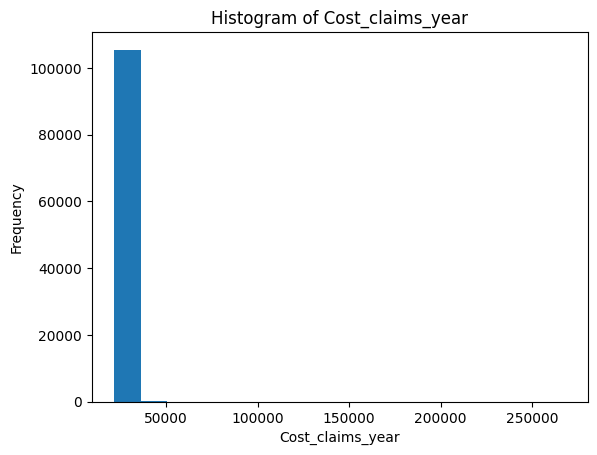

breaks,counts,mids_true,mids,widths
14491.8,nan,nan,nan,nan
28983.7,105478,2126.01,21737.8,14491.8
43475.5,58,7256.62,36229.6,14491.8
57967.4,12,14628,50721.5,14491.8
72459.2,2,24273.4,65213.3,14491.8
86951.1,2,29828.3,79705.2,14491.8
101443,0,0,94197,14491.8
115935,0,0,108689,14491.8
130427,0,0,123181,14491.8
144918,1,64404.9,137673,14491.8


In [5]:
insurance["Cost_claims_year"].hist()

In [4]:
train, test = insurance.split_frame([0.7], seed=1234)

In [5]:
print("train:%d test:%d" % (train.nrows, test.nrows))

train:73939 test:31616


In [6]:
# Feature engineering - variable transformation
train

C1,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,contract_year,birth_year,driver_age,year_dr_license,year_driving,tenure
1,1,0,4,1,2,1,0,0,213.78,0,0,0,0,1,0,0,2004,80,599,7068,0,P,nan,190,2015,1956,59,1976,39,11
2,1,0,4,2,2,1,0,0,214.84,0,0,0,0,1,0,0,2004,80,599,7068,0,P,nan,190,2015,1956,59,1976,39,11
4,2,0,4,2,2,1,0,1,213.7,0,0,0,0,1,0,0,2004,80,599,7068,0,P,nan,190,2017,1956,61,1976,41,13
5,2,0,4,2,2,1,0,1,215.83,0,0,0,0,1,0,0,2004,80,599,7068,0,P,nan,190,2017,1956,61,1976,41,13
6,3,0,15,1,2,1,0,0,380.2,0,0,0,0,3,0,0,2013,85,1229,16030,5,P,3.999,1105,2013,1975,38,1995,18,0
7,3,0,15,1,2,1,0,0,393.5,0,0,0,0,3,0,0,2013,85,1229,16030,5,P,3.999,1105,2013,1975,38,1995,18,0
8,3,0,15,1,2,1,0,0,393.5,0,0,0,0,3,0,0,2013,85,1229,16030,5,P,3.999,1105,2013,1975,38,1995,18,0
10,4,0,3,1,2,1,0,0,117.01,0,0,0,0,1,0,0,1986,6,74,1261.82,0,P,nan,87,2016,1973,43,1993,23,30
11,4,0,3,2,2,1,0,0,117.59,0,0,0,0,1,0,0,1986,6,74,1261.82,0,P,nan,87,2016,1973,43,1993,23,30
12,4,0,3,2,2,1,0,0,118.77,0,0,0,0,1,0,0,1986,6,74,1261.82,0,P,nan,87,2016,1973,43,1993,23,30


In [16]:
y = "Cost_claims_year"
# ignore = ["Type_risk", "Area", "Second_driver", "Value_vehicle","Power","N_doors","Type_fuel","Length","Weight"] 
ignore = ["ID", "Premium", "Length", "N_claims_year"] 
x = list(set(train.names) - set(ignore))

In [17]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


In [18]:
aml.train(x = x, y = y, training_frame = train, validation_frame=test)

AutoML progress: |
06:48:09.152: Project: AutoML_2_20240507_64809
06:48:09.154: Cross-validation disabled by user: no fold column nor nfolds > 1.
06:48:09.154: Setting stopping tolerance adaptively based on the training frame: 0.0036775891860784306
06:48:09.155: Build control seed: 10
06:48:09.165: training frame: Frame key: AutoML_2_20240507_64809_training_py_2_sid_8772    cols: 31    rows: 73939  chunks: 32    size: 3301933  checksum: -5585238000902477940
06:48:09.167: validation frame: Frame key: py_3_sid_8772    cols: 31    rows: 31616  chunks: 32    size: 1461037  checksum: 2833990441868234232
06:48:09.167: leaderboard frame: Frame key: py_3_sid_8772    cols: 31    rows: 31616  chunks: 32    size: 1461037  checksum: 2833990441868234232
06:48:09.167: blending frame: NULL
06:48:09.167: response column: Cost_claims_year
06:48:09.167: fold column: null
06:48:09.167: weights column: null
06:48:09.171: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,35.0,35.0,126221.0,15.0,15.0,15.0,139.0,422.0,281.22858
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2024-05-07 06:48:17,0.004 sec,0.0,1635.9437830,256.3454153,2676312.0612917,1012.6460839,262.2819141,1025452.0911838
,2024-05-07 06:48:18,0.592 sec,5.0,1612.6516936,224.6759040,2600645.4847981,986.9916861,232.5660044,974152.5884369
,2024-05-07 06:48:18,0.917 sec,10.0,1597.9048266,208.0598575,2553299.8348731,978.4263997,218.2572206,957318.2195945
,2024-05-07 06:48:18,1.320 sec,15.0,1587.9528243,198.1953943,2521594.1721791,974.3994292,210.6298654,949454.2475964
,2024-05-07 06:48:19,1.659 sec,20.0,1579.9286040,192.8575561,2496174.3938466,972.6228042,206.8242020,945995.1192156
,2024-05-07 06:48:19,1.937 sec,25.0,1573.6977016,190.1353217,2476524.4559517,973.6465441,205.9951724,947987.5927540
,2024-05-07 06:48:19,2.333 sec,30.0,1567.4094989,188.7733236,2456772.5373349,974.1904426,205.7366402,949047.0184118
,2024-05-07 06:48:20,2.643 sec,35.0,1560.7006945,190.2950532,2435786.6577871,976.4850833,208.8872077,953523.1178255


In [19]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_2_20240507_64809,976.485,953523,208.887,nan,953523
GLM_1_AutoML_2_20240507_64809,1012.63,1.02542e+06,262.262,4.58082,1.02542e+06
GBM_4_AutoML_2_20240507_64809,1012.76,1.02569e+06,214.241,nan,1.02569e+06
GBM_2_AutoML_2_20240507_64809,1017.8,1.03591e+06,211.123,nan,1.03591e+06
GBM_3_AutoML_2_20240507_64809,1018.02,1.03636e+06,215.259,nan,1.03636e+06
XRT_1_AutoML_2_20240507_64809,1092.86,1.19435e+06,226.668,2.86188,1.19435e+06
DRF_1_AutoML_2_20240507_64809,1105.58,1.22231e+06,226.85,2.68113,1.22231e+06
XGBoost_3_AutoML_2_20240507_64809,1109.78,1.23161e+06,223.818,nan,1.23161e+06
XGBoost_1_AutoML_2_20240507_64809,1153.73,1.33109e+06,299.444,nan,1.33109e+06
XGBoost_2_AutoML_2_20240507_64809,1211.43,1.46755e+06,280.459,nan,1.46755e+06


In [13]:
bst_model = aml.leader

In [15]:
h2o_wrapper = H2OProbWrapper(bst_model,feature_names) 

NameError: name 'X_train' is not defined

In [ ]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, X_train.iloc[:100,:])


In [10]:
aml = H2OAutoML(max_models=25, max_runtime_secs_per_model=30, seed=623, project_name='classification', 
                balance_classes=True, class_sampling_factors=[0.5,1.25])
%time aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
22:36:32.333: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

██
22:37:31.4: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

██
22:37:42.988: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]


22:37:54.799: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

█████████
22:38:53.671: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

██
22:39:11.367: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

█
22:39:18.136: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

█
22:39:24.872: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

█
22:39:36.230: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

███████████████████
22:42:34.95: _train param, Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]

█
22:42:51.300: _train param, Dropping bad and constant columns: [LO

key,value
Stacking strategy,cross_validation
Number of base models (used / total),18/25
# GBM base models (used / total),5/9
# XGBoost base models (used / total),6/8
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),4/5
# DRF base models (used / total),2/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [ ]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

In [ ]:
from h2o.automl import get_leaderboard
lb2 = get_leaderboard(aml, extra_columns='ALL')
lb2.head(rows=lb2.nrows)